In [1]:
import mesa
import math
import numpy as np
from model import Evacuation
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

In [2]:
sns.set_theme(style = "whitegrid", palette = "Pastel1")

# BNE mixed RF

## przykładowa symulacja

W folderze Wyniki IV nagrania symulacji:
- empty BNE, RF i 50/50
- two blocks BNE, RF i 50/50

Można je przyspieszyć i wstawić na prezentację, żeby było szybciej i łatwiej niż pokazywanie na żywo symulacji, ustawiłam też to samo seed, żeby byli ustawieni tak samo początkowo dla różnych algorytmów dzięki czemu bardziej porównywalne

## contour plot

czas ewakuacji vs liczba agentów i %BNE

In [3]:
import pandas as pd
import os

def run_experiment(agent_counts, bne_percentages, map_type, iters=50, save_path="experiment_results.csv"):
    if os.path.exists(save_path):
        results_df = pd.read_csv(save_path)
    else:
        results_df = pd.DataFrame(columns=["n", "p_BNE", "mean_time"])

    existing_rows = {(int(row["n"]), int(row["p_BNE"])) for _, row in results_df.iterrows()}

    for n_agents in agent_counts:
        for p_bne in bne_percentages:
            if (n_agents, p_bne) in existing_rows:
                continue

            params = {
                "n": n_agents,
                "width": 20,
                "height": 10,
                "door_width": 4,
                "seed": None,
                "model_type": "BNE_mixed_RF",
                "p_BNE": p_bne,
                "map_type": map_type,
                "spawn_position": "all",
                "right_door": True
            }

            output = mesa.batch_run(
                Evacuation,
                parameters=params,
                iterations=iters,
                max_steps=300,
                number_processes=10,
                data_collection_period=-1,
                display_progress=False
            )

            df = pd.DataFrame(output)
            mean_time = df.groupby("RunId").first()["Step"].mean()

            new_row = {
                "n": n_agents,
                "p_BNE": p_bne,
                "mean_time": mean_time
            }

            results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
            results_df.to_csv(save_path, index=False)

    return results_df


In [4]:
agent_counts = np.arange(100, 500, 15)
bne_percentages = np.arange(0, 101, 10)

In [7]:
def contour_map(results_df):
    pivot_table = results_df.pivot(index="n", columns="p_BNE", values="mean_time")

    min_val = np.nanmin(pivot_table.values)
    max_val = np.nanmax(pivot_table.values)
    levels = np.linspace(min_val, max_val, 10)  # np. 8 przedziałów

    plt.figure(figsize=(10, 7))
    contour = plt.contourf(
        pivot_table.columns,
        pivot_table.index,
        pivot_table.values,
        levels=levels,
        cmap="rocket"
    )
    plt.colorbar(contour, label="Mean Exit Time")
    plt.xlabel("Percentage of BNE users")
    plt.ylabel("Number of Agents")
    plt.tight_layout()
    plt.show()


In [ ]:
results_df_empty = run_experiment(agent_counts, bne_percentages, "empty", iters=50)
contour_map(results_df_empty)

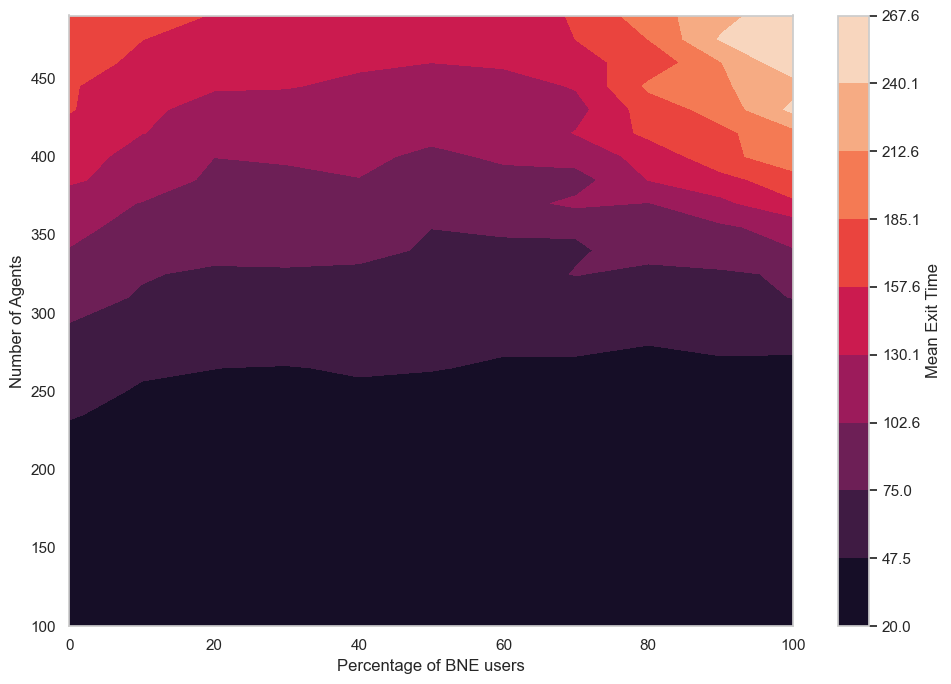

In [48]:
contour_map(results_df_empty)

In [5]:
results_df_twoblocks = run_experiment(agent_counts, bne_percentages, "two_blocks", iters=50)

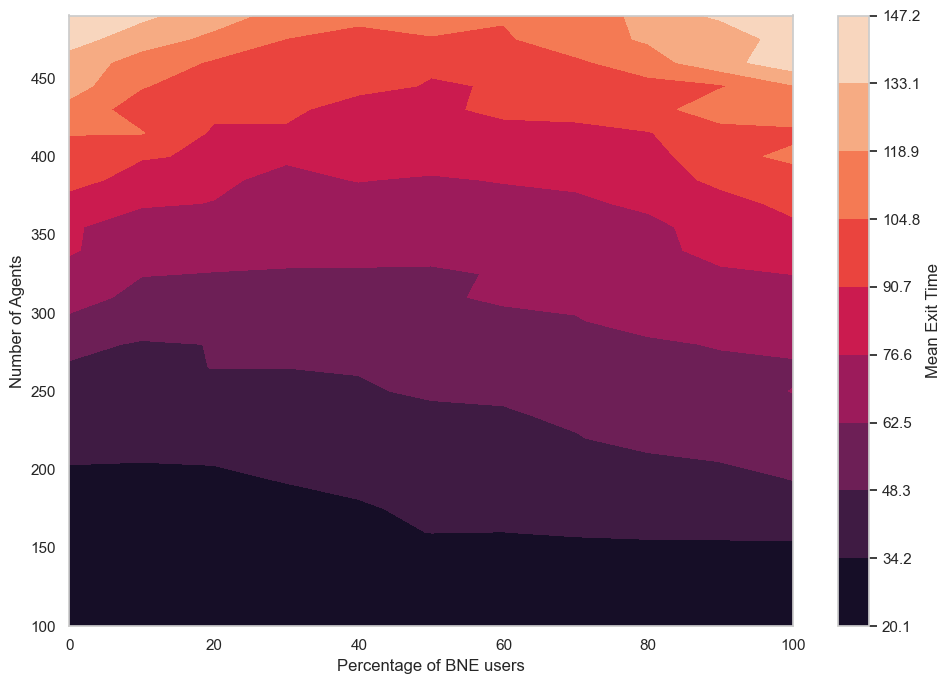

In [8]:
contour_map(results_df_twoblocks)

# Analiza pomieszczenia

zmiana szerokości drzwi/dodanie drzwi/usunięcie przeszkód

# Przykład z salą

stworzenie mniej więcej naszej sali z seminarium i porównanie czasu ewakuacji przy 1 i 2 drzwi